In [87]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [88]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta as rd

# Reflect Tables into SQLAlchemy ORM

In [89]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [90]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///../sqlalchemy-challenge/hawaii.sqlite')

In [91]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [92]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [93]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [94]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [95]:
# Find the most recent date in the data set.
# result return an iterable object
result = session.execute('select MAX(date) from measurement').fetchall()
most_recent_date = None
# Put result through a for loop to return it as a string
for row in result:
    most_recent_date = row[0]
most_recent_date

'2017-08-23'

In [96]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
date = str(most_recent_date).split('-')
year = int(date[0])
month = int(date[1])
day = int(date[2])
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime(year, month, day)

# Calculate the date one year from the last date in data set.
twelve_months = most_recent_date + rd(months=-12)
twelve_months


# Perform a query to retrieve the data and precipitation scores
result1=session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > twelve_months).all()
result1
# Save the query results as a Pandas DataFrame and set the index to the date column
date_list= []
prcp_list = []

for row in result1:
    date = row[0]
    prcp = row[1]
    date_list.append(date)
    prcp_list.append(prcp)

info = {
    "date":date_list,
    "prcp":prcp_list
}
prcp_pd=pd.DataFrame(data=info)

# Sort the dataframe by date
sorted_prcp_pd=prcp_pd.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_prcp_pd['prcp'] = sorted_prcp_pd['prcp'].fillna(0)
sorted_prcp_pd

,date,prcp
0,2016-08-24,0.08
1006,2016-08-24,0.00
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
...,...,...
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00


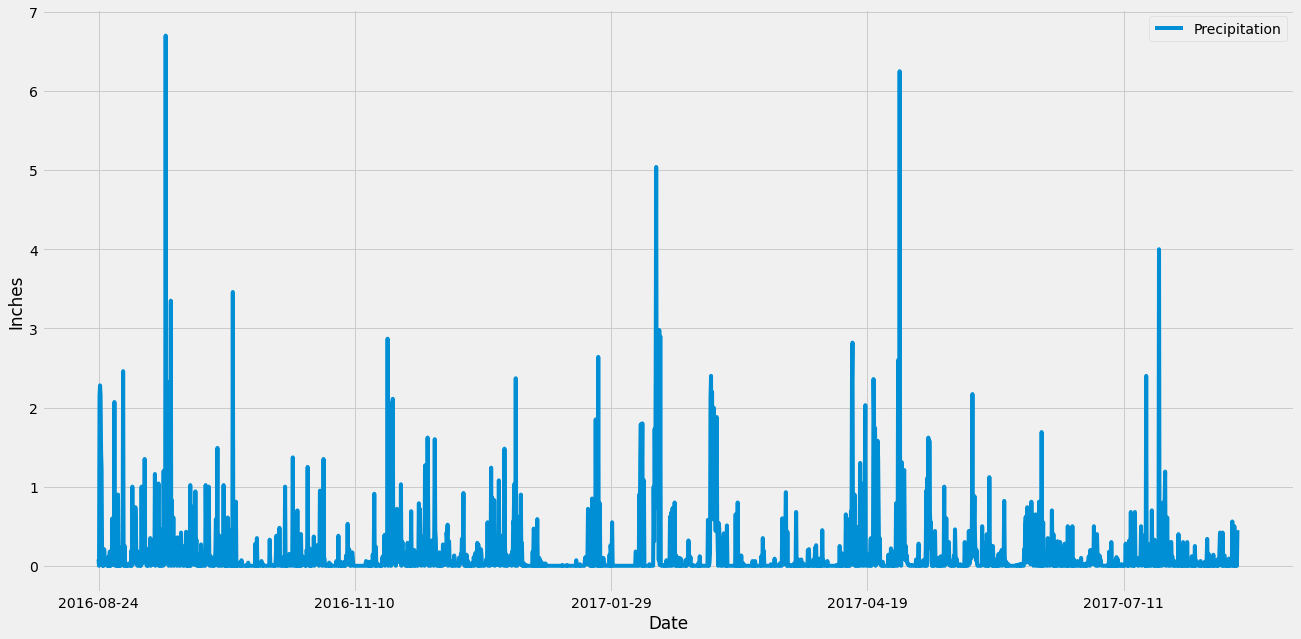

In [97]:
# sorted_prcp_pd.plot.bar(x='date',y='prcp')
# Using Pandas Plot
sorted_prcp_pd.set_index(sorted_prcp_pd['date'], inplace=True)
sorted_prcp_pd = sorted_prcp_pd.sort_index()
fig = sorted_prcp_pd.plot(rot=0, figsize=(20, 10)).get_figure()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(['Precipitation'], loc="upper right")
# plt.show()
fig.savefig('prcp.png')

In [98]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_prcp_pd.describe()


,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [99]:
# Design a query to calculate the total number stations in the dataset
session.query(station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d7568e1220>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

In [100]:
session.query(measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d7568f0b50>,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01'}

In [101]:
session.query(func.count(station.station)).all()
# result_ = session.query(func.count(measurement.station.distinct())).first()
# result_

[(9,)]

In [102]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.execute("SELECT station, COUNT(station) as total_stations FROM measurement GROUP BY station ORDER BY total_stations DESC").all()
most_active_station = active_station[0][0]
print(f"Station {most_active_station} has the most rows.")

Station USC00519281 has the most rows.


In [103]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.execute(f"SELECT station, MAX(tobs) as max_temp, MIN(tobs) as min_temp, AVG(tobs) as avg_temp FROM measurement WHERE station = '{most_active_station}'").all()

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [104]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Using the twelve_months calculated from the prcp table
result2=session.query(measurement.date, measurement.tobs).\
    filter(measurement.date > twelve_months).\
        filter(measurement.station == most_active_station).all()
result2

#save the temps query in a Pandas DataFrame
tobs_list = []
for row in result2:
    tobs = row [1]
    tobs_list.append(tobs)

tobs_list
info2 = {
     "temp" : tobs_list
 }

tobs_pd = pd.DataFrame(data=info2)
tobs_pd

,temp
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


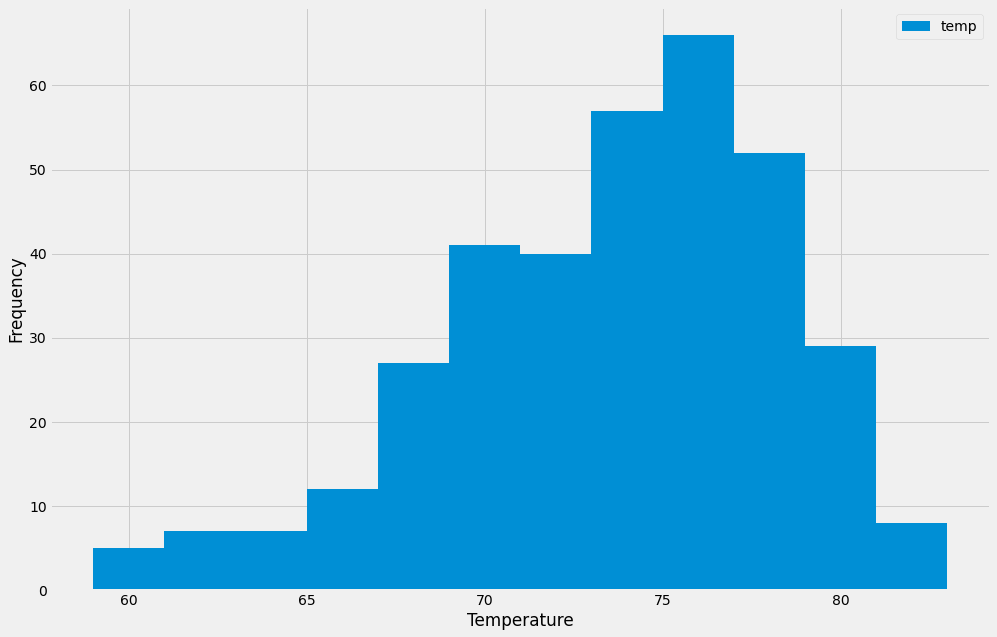

In [105]:
#Using Pandas Plot
fig1 = tobs_pd.plot.hist(bins=12, rot=0, figsize=(15,10)).get_figure()
plt.xlabel("Temperature")
fig1.savefig("most_frequent_station_temps.png")

# Close session

In [106]:
# Close Session
session.close()